In [ ]:
# Spam Email Classifier

This notebook builds a **Spam vs Ham (Not Spam)** classifier using the
SMS Spam Collection dataset.

Pipeline:
1. Load dataset
2. Preprocess text (lowercase, remove URLs/special chars, stopword removal, lemmatization)
3. Convert text to TF-IDF vectors
4. Train and evaluate **Multinomial Naive Bayes** and **Logistic Regression**
5. Show confusion matrix, ROC curve, and precision-recall curves

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...


Upload spam.csv or SMSSpamCollection when prompted...


[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Saving spam.csv to spam (1).csv
Using file: spam (1).csv
Dataset size: 5572
label_num
0    4825
1     747
Name: count, dtype: int64
Train size: 4457 Test size: 1115

=== Naive Bayes ===
              precision    recall  f1-score   support

           0     0.9669    0.9990    0.9827       966
           1     0.9915    0.7785    0.8722       149

    accuracy                         0.9695      1115
   macro avg     0.9792    0.8887    0.9274      1115
weighted avg     0.9702    0.9695    0.9679      1115



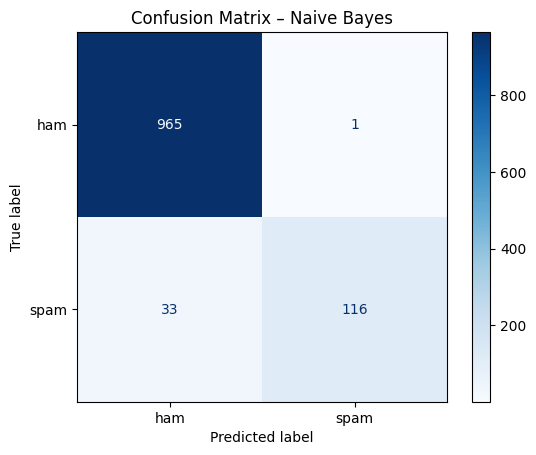


=== Logistic Regression ===
              precision    recall  f1-score   support

           0     0.9679    0.9990    0.9832       966
           1     0.9915    0.7852    0.8764       149

    accuracy                         0.9704      1115
   macro avg     0.9797    0.8921    0.9298      1115
weighted avg     0.9711    0.9704    0.9689      1115



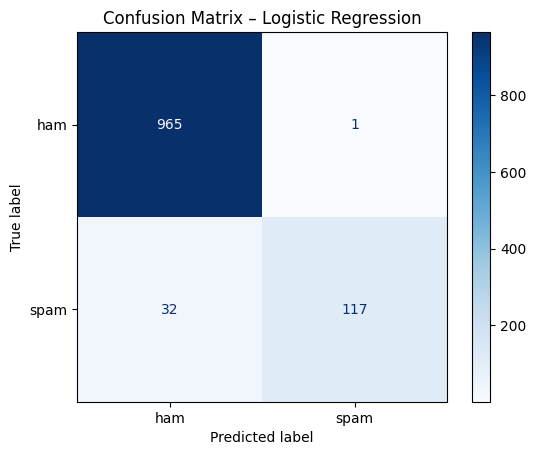

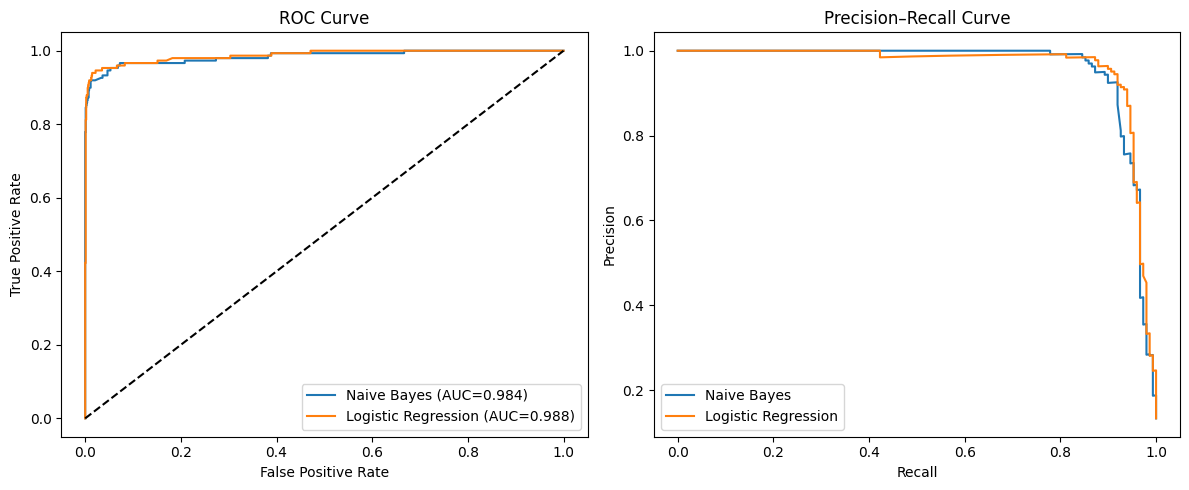

In [23]:


# 1. Install & import packages
!pip install -q scikit-learn pandas matplotlib seaborn nltk

import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc, precision_recall_curve
)
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download NLTK resources (new versions require punkt_tab)
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')   # <-- important for NLTK 3.8+
nltk.download('wordnet')

# 2. Upload the dataset (e.g., spam.csv or SMSSpamCollection)
from google.colab import files
print("Upload spam.csv or SMSSpamCollection when prompted...")
uploaded = files.upload()
data_file = list(uploaded.keys())[0]
print("Using file:", data_file)

# 3. Load the dataset robustly
df = pd.read_csv(data_file, encoding='latin-1', engine='python')
# Handle common Kaggle format (v1/v2 plus extra columns)
if 'v1' in df.columns and 'v2' in df.columns:
    df = df[['v1','v2']].rename(columns={'v1':'label','v2':'text'})
elif df.shape[1] >= 2 and {'label','text'}.issubset(df.columns) == False:
    df = df.iloc[:, :2]
    df.columns = ['label','text']
else:
    df = df.rename(columns=lambda c: c.lower())

# Drop NaNs
df = df.dropna(subset=['label','text']).reset_index(drop=True)

# Normalize labels
df['label'] = df['label'].astype(str).str.strip().str.lower()

# Map to binary 0=ham, 1=spam
def map_label(x):
    s = str(x).lower()
    if 'spam' in s:
        return 1
    return 0
df['label_num'] = df['label'].apply(map_label)

print("Dataset size:", len(df))
print(df['label_num'].value_counts())

# 4. Preprocess text
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(s):
    s = str(s).lower()
    s = re.sub(r'http\S+|www\S+', ' ', s)
    s = re.sub(r'[^a-z0-9\s]', ' ', s)
    tokens = nltk.word_tokenize(s)
    tokens = [t for t in tokens if t not in stop_words and len(t) > 1]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return ' '.join(tokens)

df['clean_text'] = df['text'].apply(preprocess_text)

# 5. Train/test split
X = df['clean_text']
y = df['label_num']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Train size:", len(X_train), "Test size:", len(X_test))

# 6. TF-IDF
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
Xtr = tfidf.fit_transform(X_train)
Xte = tfidf.transform(X_test)

# 7. Train models
nb = MultinomialNB()
nb.fit(Xtr, y_train)

lr = LogisticRegression(max_iter=2000)
lr.fit(Xtr, y_train)

# 8. Evaluation
for name, model in [('Naive Bayes', nb), ('Logistic Regression', lr)]:
    preds = model.predict(Xte)
    print("\n=== {} ===".format(name))
    print(classification_report(y_test, preds, digits=4))
    cm = confusion_matrix(y_test, preds)
    ConfusionMatrixDisplay(cm, display_labels=['ham','spam']).plot(cmap='Blues')
    plt.title(f"Confusion Matrix – {name}")
    plt.show()

# 9. ROC and Precision-Recall curves
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
for name, model in [('Naive Bayes', nb), ('Logistic Regression', lr)]:
    scores = model.predict_proba(Xte)[:,1]
    fpr, tpr, _ = roc_curve(y_test, scores)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc(fpr,tpr):.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()

plt.subplot(1,2,2)
for name, model in [('Naive Bayes', nb), ('Logistic Regression', lr)]:
    scores = model.predict_proba(Xte)[:,1]
    precision, recall, _ = precision_recall_curve(y_test, scores)
    plt.plot(recall, precision, label=name)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend()

plt.tight_layout()
plt.show()
